# Backtesting with [**vectorbt**](https://github.com/polakowo/vectorbt)
* Data Acquisition (**yfinance**)
* Statistical and Technical Analysis (**pandas_ta**)
* Backtesting Analysis and Results (**vectorbt**)

### Initializations

In [1]:
import asyncio
import itertools
from datetime import datetime

from IPython import display

import numpy as np
import pandas as pd
import pandas_ta as ta
import vectorbt as vbt

import plotly.graph_objects as go

%matplotlib inline

Package Versions:
Numpy v1.20.3
Pandas v1.2.4
vectorbt >= v0.18.1

Pandas TA v0.2.86b0
To install the Latest Version:
$ pip install -U git+https://github.com/twopirllc/pandas-ta



# **vectorbt** Theme and Portfolio Settings

In [79]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1m" # Daily

# Predefine vectorbt Portfolio settings
# vbt.settings.portfolio["init_cash"] = 100
vbt.settings.portfolio["fees"] = 0.0025 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0025 # 0.25%
# vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
# pf_settings

Portfolio Settings [Initial]


## Helper Methods

In [42]:
def combine_stats(pf: vbt.portfolio.base.Portfolio, ticker: str, strategy: str, mode: int = 0):
    header = pd.Series({
        "Run Time": ta.get_time(full=False, to_string=True),
        "Mode": "LIVE" if mode else "TEST",
        "Strategy": strategy,
        "Direction": vbt.settings.portfolio["signal_direction"],
        "Symbol": ticker.upper(),
        "Fees [%]": 100 * vbt.settings.portfolio["fees"],
        "Slippage [%]": 100 * vbt.settings.portfolio["slippage"],
        "Accumulate": vbt.settings.portfolio["accumulate"],
    })
    rstats = pf.returns_stats().dropna(axis=0).T
    stats = pf.stats().dropna(axis=0).T
    joint = pd.concat([header, stats, rstats])
    return joint[~joint.index.duplicated(keep="first")]

def earliest_common_index(d: dict):
    """Returns index of the earliest common index of all DataFrames in the dict"""
    min_date = None
    for df in d.values():
        if min_date is None:
            min_date = df.index[0]
        elif min_date < df.index[0]:
            min_date = df.index[0]
    return min_date

def dl(tickers: list, same_start: bool = False, **kwargs):
    if isinstance(tickers, str):
        tickers = [tickers]
    
    if not isinstance(tickers, list) or len(tickers) == 0:
        print("Must be a non-empty list of tickers or symbols")
        return

    if "limit" in kwargs and kwargs["limit"] and len(tickers) > kwargs["limit"]:
        from itertools import islice            
        tickers = list(islice(tickers, kwargs["limit"]))
        print(f"[!] Too many assets to compare. Using the first {kwargs['limit']}: {', '.join(tickers)}")

    print(f"[i] Downloading: {', '.join(tickers)}")

    received = {}
    if len(tickers):
        _df = pd.DataFrame()
        for ticker in tickers:
            received[ticker] = _df.ta.ticker(ticker, **kwargs)
            print(f"[+] {ticker}{received[ticker].shape} {ta.get_time(full=False, to_string=True)}")
    
    if same_start and len(tickers) > 1:
        earliestci = earliest_common_index(received)
        print(f"[i] Earliest Common Date: {earliestci}")
        result = {ticker:df[df.index > earliestci].copy() for ticker,df in received.items()}
    else:
        result = received
    print(f"[*] Download Complete\n")
    return result

def dtmask(df: pd.DataFrame, start: datetime, end: datetime):
    return df.loc[(df.index >= start) & (df.index <= end), :].copy()

def show_data(d: dict):
    [print(f"{t}[{df.index[0]} - {df.index[-1]}]: {df.shape} {df.ta.time_range:.2f} years") for t,df in d.items()]
    
def trade_table(pf: vbt.portfolio.base.Portfolio, k: int = 1, total_fees: bool = False):
    if not isinstance(pf, vbt.portfolio.base.Portfolio): return
    k = int(k) if isinstance(k, int) and k > 0 else 1

    df = pf.trades.records[["status", "direction", "size", "entry_price", "exit_price", "return", "pnl", "entry_fees", "exit_fees"]]
    if total_fees:
        df["total_fees"] = df["entry_fees"] + df["exit_fees"]

    print(f"\nLast {k} of {df.shape[0]} Trades\n{df.tail(k)}\n")

# Data Acquisition

#### Specify Symbols for Benchmarks and Assets

In [51]:
df = pd.read_json(r'./freqtrade-user-data/data/binance/BTC_USDT-1m.json')
df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

dftime = pd.to_datetime(df['timestamp'], unit='ms')
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
df.set_index(pd.DatetimeIndex(dftime), inplace=True, drop=True)
df.drop(columns=['timestamp'])
len(df)

239887

In [43]:

from datetime import datetime, timedelta
import pytz
symbol = 'BTC-USD'
metric = 'total_return'

# time_buffer = timedelta(minutes=100)  # buffer before to pre-calculate SMA/EMA, best to set to max window
freq = '1m'

In [35]:
# ddf = df.loc[(df.index >= start_date) & (df.index <= end_date)].copy()
# len(ddf)

11521

### Define Testing Dates and Ranges

In [12]:
start_date = datetime(2021, 6, 9)  # time period for analysis, must be timezone-aware
end_date = datetime(2021, 6, 17)


### Select and Benchmark and Asset to Backtest

In [52]:
# benchmark_name = "SPY" # Select a Benchmark
asset_name = "BTC" # Select an Asset

# benchmarkdf = benchmarks[benchmark_name]
# assetdf     = assets[asset_name]
assetdf = df
# Set True if you want to constrain Data between start_date & end_date
common_range = True
if common_range:
    crs = f" from {start_date} to {end_date}"
#     benchmarkdf = dtmask(benchmarkdf, start_date, end_date)
    assetdf = dtmask(assetdf, start_date, end_date)

# Update DataFrame names
# benchmarkdf.name = benchmark_name
assetdf.name = asset_name
# print(f"Analysis of: {benchmarkdf.name} and {assetdf.name}{crs if common_range else ''}")

#### Sanity Check

In [80]:
assetdf.head()

,timestamp,open,high,low,close,volume,TS_Trends,TS_Trades,TS_Entries,TS_Exits
timestamp,,,,,,,,,,
2021-06-09 00:00:00,1623196800000,33380.80,33412.52,33308.64,33409.93,74.620700,False,0,False,False
2021-06-09 00:01:00,1623196860000,33406.00,33540.47,33384.34,33522.13,90.643872,False,0,False,False
2021-06-09 00:02:00,1623196920000,33522.56,33522.56,33424.16,33474.15,55.995944,False,0,False,False
2021-06-09 00:03:00,1623196980000,33474.16,33499.89,33452.04,33473.29,39.980787,False,0,False,False
2021-06-09 00:04:00,1623197040000,33473.29,33474.24,33383.62,33403.48,26.282153,False,0,False,False


## Creating Trading Signals for **vectorbt**
**vectorbt** can create a Backtest using ```vbt.Portfolio.from_signals(*args, **kwargs)``` based on trends can you define with **Pandas TA**.

### Trend Creation
A **Trend** is the result of some calculation or condition of one or more indicators. For simplicity, a _Trend_ is either ```True``` or ```1``` and _No Trend_ is ```False``` or ```0```. Using the **Hello World** of Trends, the **Golden/Death Cross**, it's Trend is _Long_ when ```long = ma(close, 50) > ma(close, 200) ``` and _Short_ when ```short = ma(close, 50) < ma(close, 200) ```. 

In [49]:
# Example Long Trends for the selected Asset
# * Uncomment others for exploration or replace them with your own TA Trend Strategy
def trends(df: pd.DataFrame, mamode: str = "sma", fast: int = 50, slow: int = 200):
    return ta.ma(mamode, df['close'], length=fast) > ta.ma(mamode, df['close'], length=slow) # SMA(fast) > SMA(slow) "Golden/Death Cross"
#     return ta.increasing(ta.ma(mamode, df.close, length=fast)) # Increasing MA(fast)
#     return ta.macd(df.close, fast, slow).iloc[:,1] > 0 # MACD Histogram is positive

### Display Trends

In [47]:
trend_kwargs = {"mamode": "sma", "fast": 50, "slow": 200}

<AxesSubplot:title={'center':'BTC Trends'}, xlabel='timestamp'>

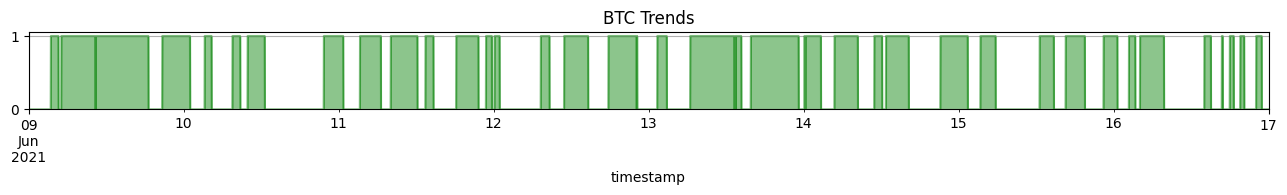

In [55]:
asset_trends = trends(assetdf, **trend_kwargs)
asset_trends.copy().astype(int).plot(figsize=(16, 1), kind="area", color=["green"], alpha=0.45, title=f"{assetdf.name} Trends", grid=True)

### **Trend Signals** 
Given a _Trend_, **Trend Signals** returns the _Trend_, _Trades_, _Entries_ and _Exits_ as boolean integers. When ```asbool=True```, it returns _Trends_, _Entries_ and _Exits_ as boolean values which is helpful when combined with the [**vectorbt**](https://github.com/polakowo/vectorbt) backtesting package.

In [56]:
# trade_offset = 0 for Live Signals (close is last price)
# trade_offset = 1 for Backtesting
LIVE = 0

# benchmark_signals = assetdf.ta.tsignals(benchmark_trends, asbool=True, trade_offset=LIVE, append=True)
# benchmark_signals.tail()

In [57]:
asset_signals = assetdf.ta.tsignals(asset_trends, asbool=True, trade_offset=LIVE, append=True)
asset_signals.tail()

,TS_Trends,TS_Trades,TS_Entries,TS_Exits
timestamp,,,,
2021-06-16 23:56:00,False,0,False,False
2021-06-16 23:57:00,False,0,False,False
2021-06-16 23:58:00,False,0,False,False
2021-06-16 23:59:00,False,0,False,False
2021-06-17 00:00:00,False,0,False,False


## Creating **vectorbt** Portfolios
* [**vectorbt** Portfolio Options](https://polakowo.io/vectorbt/docs/portfolio/base.html)

### Buy 'N Hold Portfolios with their Single Trade and Performance Statistics

In [20]:
# Benchmark Buy and Hold (BnH) Strategy
benchmarkpf_bnh = vbt.Portfolio.from_holding(benchmarkdf.close)
print(trade_table(benchmarkpf_bnh))
combine_stats(benchmarkpf_bnh, benchmarkdf.name, "Buy and Hold", LIVE)


Last 1 of 1 Trades
   status  direction      size  entry_price  exit_price    return       pnl  \
0       0          0  1.141912    87.354056   89.275963  0.019501  1.945272   

   entry_fees  exit_fees  
0    0.249377        0.0  

None


/Users/johnsmith/opt/anaconda3/envs/py38/lib/python3.8/site-packages/vectorbt/portfolio/trades.py:252: RuntimeWarning: invalid value encountered in true_divide
  return self.wrapper.wrap_reduced(win_count / total_count, group_by=group_by, **wrap_kwargs)
/Users/johnsmith/opt/anaconda3/envs/py38/lib/python3.8/site-packages/vectorbt/portfolio/trades.py:252: RuntimeWarning: invalid value encountered in true_divide
  return self.wrapper.wrap_reduced(win_count / total_count, group_by=group_by, **wrap_kwargs)


Run Time                  Wednesday June 16, 2021, NYSE: 22:10:34
Mode                                                         TEST
Strategy                                             Buy and Hold
Direction                                                longonly
Symbol                                                        SPY
Fees [%]                                                     0.25
Slippage [%]                                                 0.25
Accumulate                                                  False
Start                                         2005-01-03 00:00:00
End                                           2009-12-31 00:00:00
Duration                                       1259 days 00:00:00
Init. Cash                                                  100.0
Total Profit                                             1.945272
Total Return [%]                                         1.945272
Benchmark Return [%]                                     2.455635
Position C

In [58]:
# Asset Buy and Hold (BnH) Strategy
assetpf_bnh = vbt.Portfolio.from_holding(assetdf['close'])
print(trade_table(assetpf_bnh))
combine_stats(assetpf_bnh, assetdf.name, "Buy and Hold", LIVE)


Last 1 of 1 Trades
   status  direction      size   entry_price  exit_price    return        pnl  \
0       0          0  0.002978  33493.454825    38392.74  0.143776  14.341735   

   entry_fees  exit_fees  
0    0.249377        0.0  

None


/Users/johnsmith/opt/anaconda3/envs/py38/lib/python3.8/site-packages/vectorbt/portfolio/trades.py:252: RuntimeWarning: invalid value encountered in true_divide
  return self.wrapper.wrap_reduced(win_count / total_count, group_by=group_by, **wrap_kwargs)
/Users/johnsmith/opt/anaconda3/envs/py38/lib/python3.8/site-packages/vectorbt/portfolio/trades.py:252: RuntimeWarning: invalid value encountered in true_divide
  return self.wrapper.wrap_reduced(win_count / total_count, group_by=group_by, **wrap_kwargs)


Run Time                  Thursday June 17, 2021, NYSE: 0:11:30
Mode                                                       TEST
Strategy                                           Buy and Hold
Direction                                              longonly
Symbol                                                      BTC
Fees [%]                                                   0.25
Slippage [%]                                               0.25
Accumulate                                                False
Start                                       2021-06-09 00:00:00
End                                         2021-06-17 00:00:00
Duration                                        8 days 00:01:00
Init. Cash                                                100.0
Total Profit                                          14.341735
Total Return [%]                                      14.341735
Benchmark Return [%]                                  14.914159
Position Coverage [%]                   

### Signal Portfolios with their Last 'k' Trades and Performance Statistics

In [60]:
# Asset Portfolio from Trade Signals
assetpf_signals = vbt.Portfolio.from_signals(
    assetdf.close,
    entries=asset_signals.TS_Entries,
    exits=asset_signals.TS_Exits,
)
trade_table(assetpf_signals, k=5)
combine_stats(assetpf_signals, assetdf.name, "Long Strategy", LIVE)


Last 5 of 40 Trades
    status  direction      size   entry_price    exit_price    return  \
35       1          0  0.002108  39253.649400  38859.836925 -0.015007   
36       1          0  0.002095  38917.942225  38516.118375 -0.015299   
37       1          0  0.002044  39268.386150  38324.757975 -0.028970   
38       1          0  0.002001  38950.864325  38539.310250 -0.015540   
39       1          0  0.001971  38931.987250  38489.345475 -0.016341   

         pnl  entry_fees  exit_fees  
35 -1.242002    0.206898   0.204822  
36 -1.247186    0.203801   0.201696  
37 -2.325614    0.200691   0.195868  
38 -1.211408    0.194891   0.192832  
39 -1.254154    0.191870   0.189689  



Run Time                  Thursday June 17, 2021, NYSE: 0:14:45
Mode                                                       TEST
Strategy                                          Long Strategy
Direction                                              longonly
Symbol                                                      BTC
Fees [%]                                                   0.25
Slippage [%]                                               0.25
Accumulate                                                False
Start                                       2021-06-09 00:00:00
End                                         2021-06-17 00:00:00
Duration                                        8 days 00:01:00
Init. Cash                                                100.0
Total Profit                                         -24.314278
Total Return [%]                                     -24.314278
Benchmark Return [%]                                  14.914159
Position Coverage [%]                   

## Buy and Hold Plots

In [61]:
vbt.settings.set_theme("seaborn")

### Asset

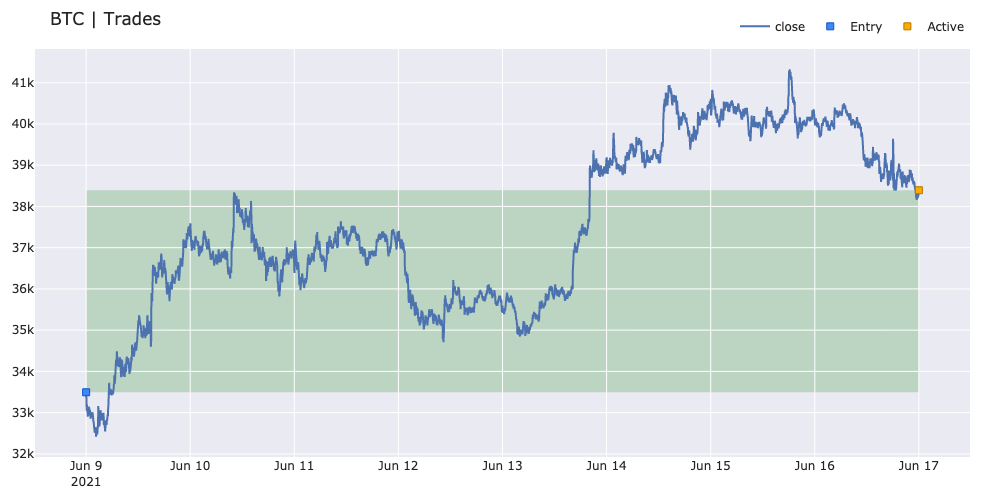

In [62]:
assetpf_bnh.trades.plot(title=f"{assetdf.name} | Trades", height=cheight, width=cwidth).show_png()

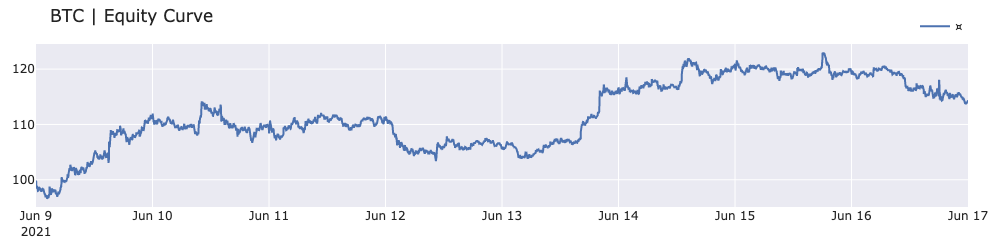

In [63]:
assetpf_bnh.value().vbt.plot(title=f"{assetdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

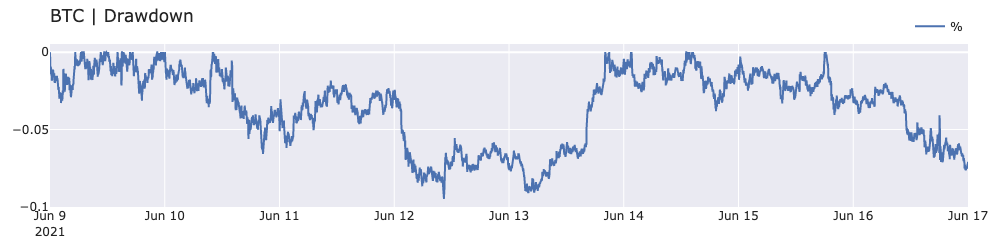

In [64]:
assetpf_bnh.drawdown().vbt.plot(title=f"{assetdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

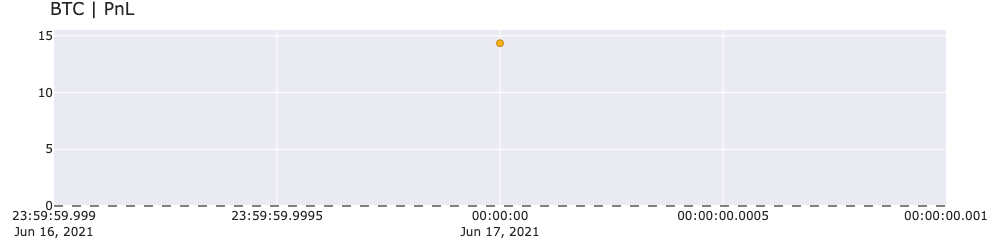

In [66]:
assetpf_bnh.trades.plot_pnl(title=f"{assetdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

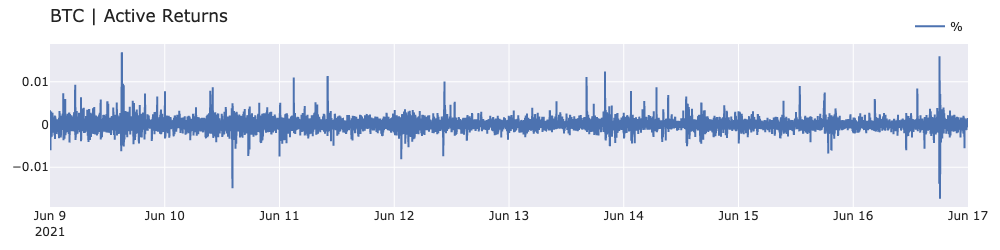

In [67]:
assetpf_bnh.active_returns().vbt.plot(title=f"{assetdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

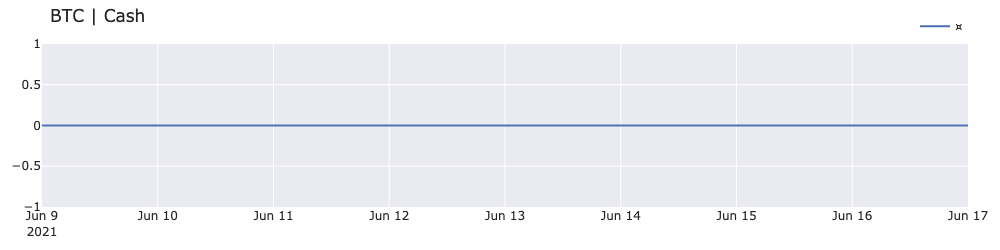

In [68]:
assetpf_bnh.cash().vbt.plot(title=f"{assetdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

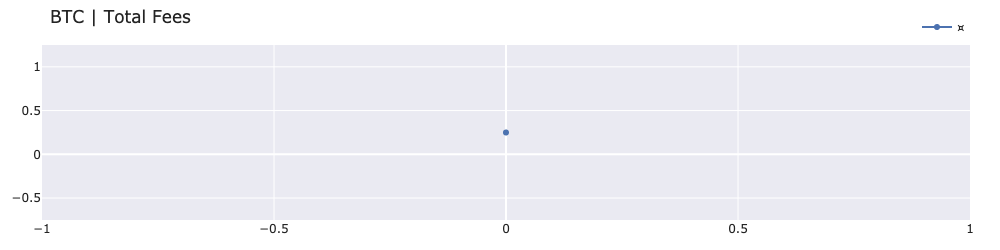

In [69]:
total_assetfees = assetpf_bnh.trades.records_readable["Entry Fees"] + assetpf_bnh.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{assetdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

## Signal Plots

In [70]:
vbt.settings.set_theme("dark")

### Benchmark

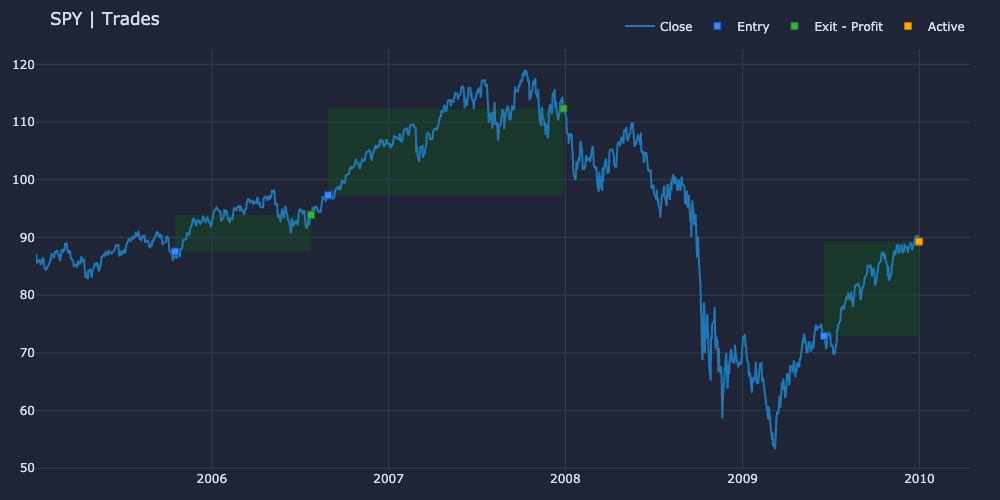

In [39]:
benchmarkpf_signals.trades.plot(title=f"{benchmarkdf.name} | Trades", height=cheight, width=cwidth).show_png()

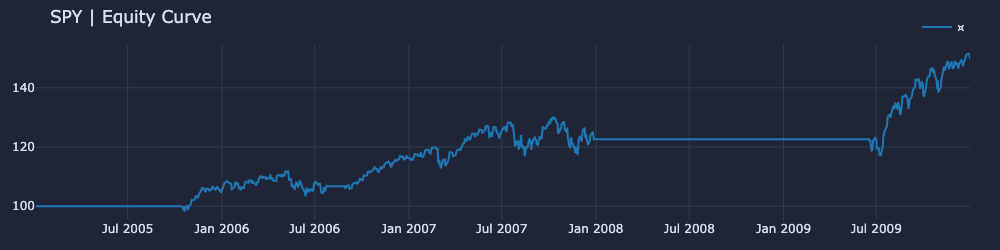

In [40]:
benchmarkpf_signals.value().vbt.plot(title=f"{benchmarkdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

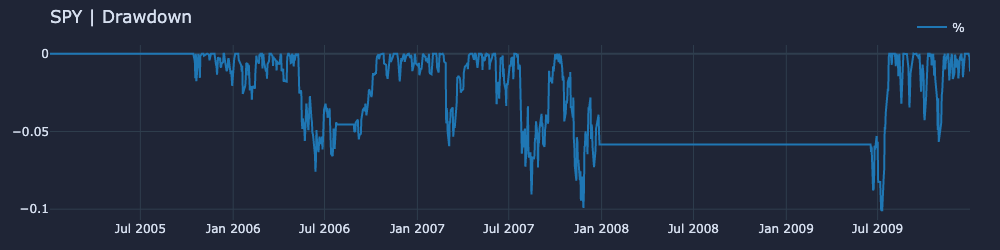

In [41]:
benchmarkpf_signals.drawdown().vbt.plot(title=f"{benchmarkdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

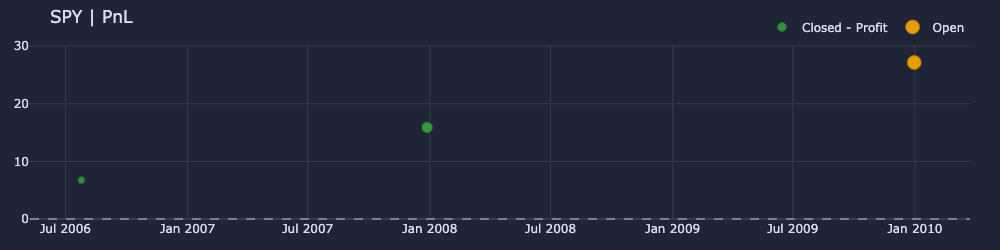

In [42]:
benchmarkpf_signals.trades.plot_pnl(title=f"{benchmarkdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

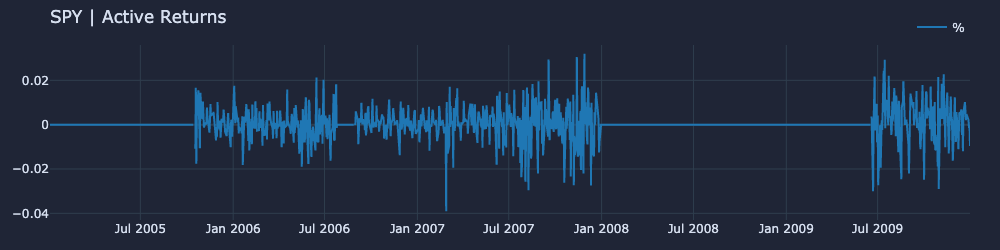

In [43]:
benchmarkpf_signals.active_returns().vbt.plot(title=f"{benchmarkdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

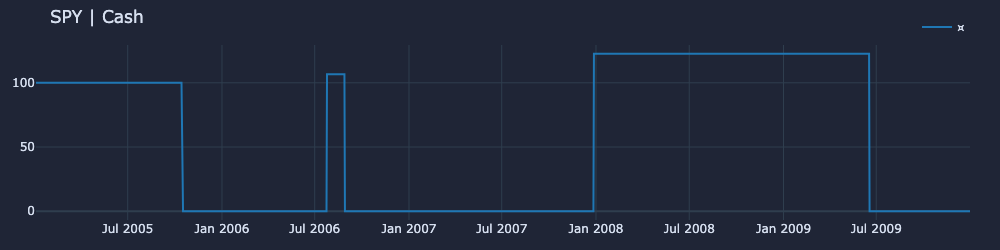

In [44]:
benchmarkpf_signals.cash().vbt.plot(title=f"{benchmarkdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

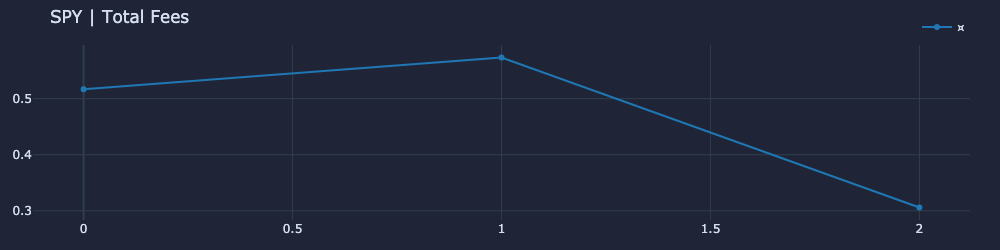

In [45]:
total_assetfees = benchmarkpf_signals.trades.records_readable["Entry Fees"] + benchmarkpf_signals.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{benchmarkdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

### Asset

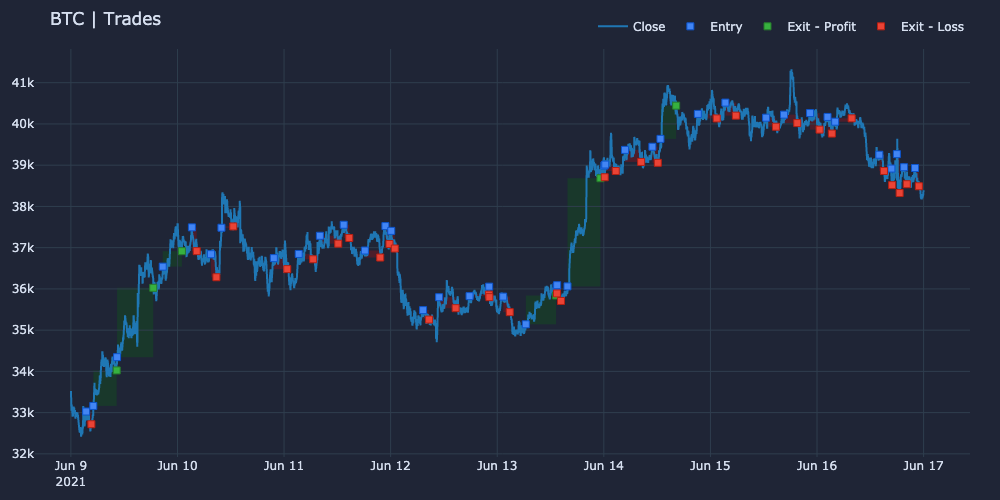

In [72]:
assetpf_signals.trades.plot(title=f"{assetdf.name} | Trades", height=cheight, width=cwidth).show_png()

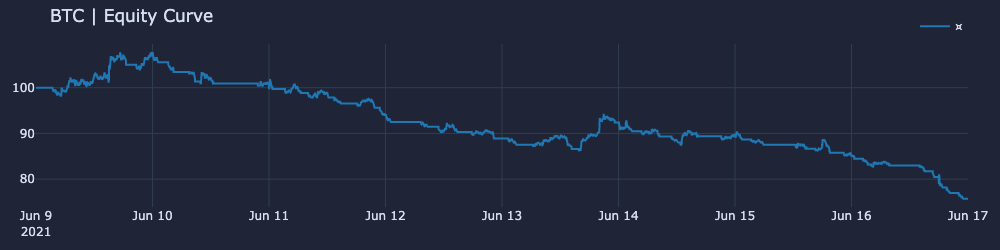

In [73]:
assetpf_signals.value().vbt.plot(title=f"{assetdf.name} | Equity Curve", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

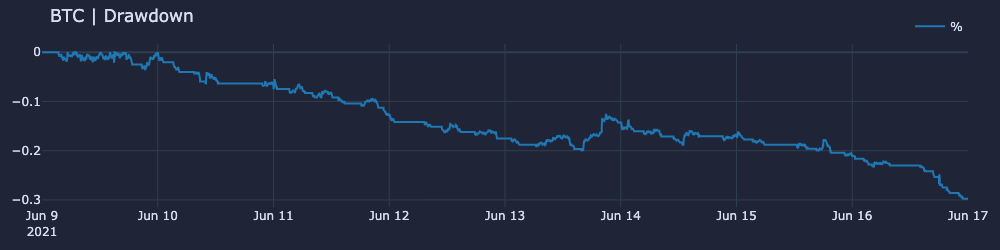

In [74]:
assetpf_signals.drawdown().vbt.plot(title=f"{assetdf.name} | Drawdown", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

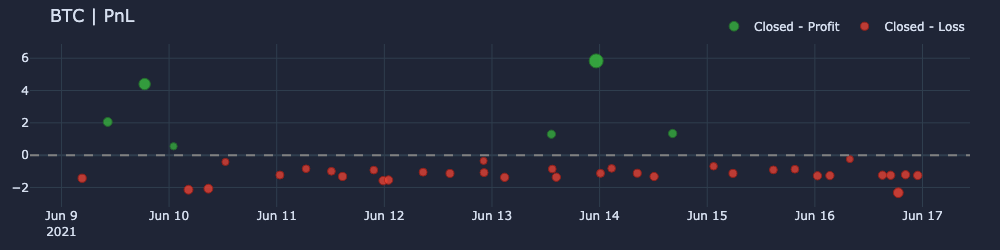

In [75]:
assetpf_signals.trades.plot_pnl(title=f"{assetdf.name} | PnL", height=cheight // 2, width=cwidth).show_png()

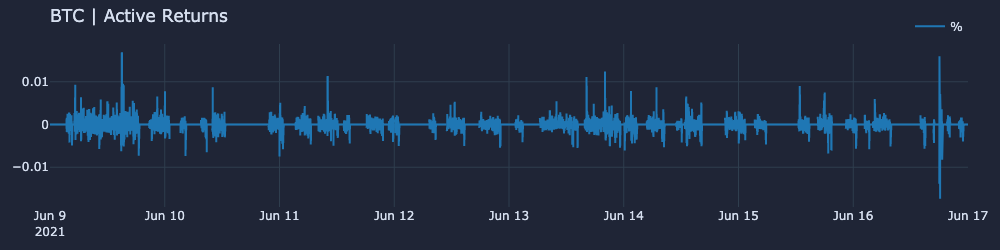

In [76]:
assetpf_signals.active_returns().vbt.plot(title=f"{assetdf.name} | Active Returns", trace_kwargs=dict(name="%"), height=cheight // 2, width=cwidth).show_png()

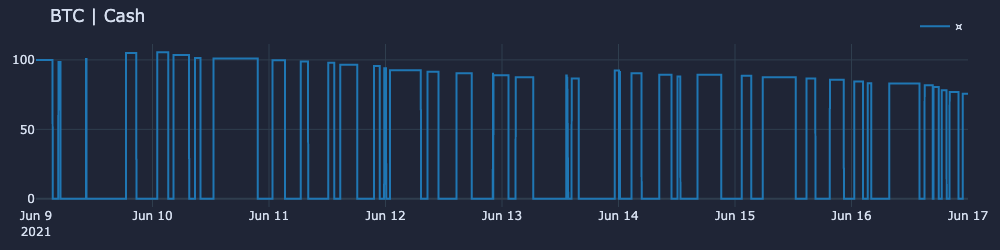

In [77]:
assetpf_signals.cash().vbt.plot(title=f"{assetdf.name} | Cash", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

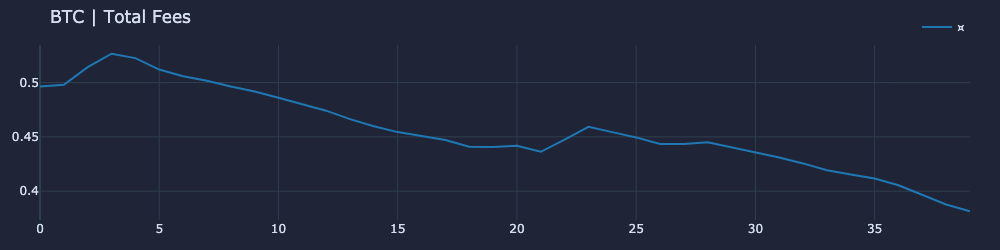

In [78]:
total_assetfees = assetpf_signals.trades.records_readable["Entry Fees"] + assetpf_signals.trades.records_readable["Exit Fees"]
total_assetfees.vbt.plot(title=f"{assetdf.name} | Total Fees", trace_kwargs=dict(name=u"\u00A4"), height=cheight // 2, width=cwidth).show_png()

# Disclaimer
* All investments involve risk, and the past performance of a security, industry, sector, market, financial product, trading strategy, or individual’s trading does not guarantee future results or returns. Investors are fully responsible for any investment decisions they make. Such decisions should be based solely on an evaluation of their financial circumstances, investment objectives, risk tolerance, and liquidity needs.

* Any opinions, news, research, analyses, prices, or other information offered is provided as general market commentary, and does not constitute investment advice. I will not accept liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.